### Importations des librairies

In [64]:
import matplotlib.pyplot as plt
from pysheds.grid import Grid
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import plotly.graph_objects as go
import cv2
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

### Conversion de la zone de travail en raster

In [ ]:
# Importation carte
path = "merged_map.tif" #Chemin d'accès vers le dem au format .tif. On télécharge plusieurs dem au format .tif qui couvrent toute
                        #la région de travail sur USGS puis on merge ces dem avec ARCGIS ou QGIS pour obtenir un grand dem qui 
                        #couvre toute la région de d'étude.

grid = Grid.from_raster(path, data_name="dem")
dem = grid.read_raster(path)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.view(dem), cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.title('Digital elevation map', size=14)
plt.tight_layout()

In [ ]:
# Création des cartes constantes -> carte des denivelés filled, des directions, des accumulations et des gradients
# WARNING : Met plusieurs minutes à tourner (6min sur mon ordinateur)
pit_filled_dem = grid.fill_pits(dem)
flooded_dem = grid.fill_depressions(pit_filled_dem)
inflated_dem = grid.resolve_flats(flooded_dem) #dem
fdir = grid.flowdir(inflated_dem) #carte des directions. Numpy array de même taille que le dem. Pour chaque case donne la direction
                                  #vers laquelle irait une goutte d'eau à partir de ce point. Encodage ordinal (les directions sont
                                  #représentées par des puissances de 2)
acc = grid.accumulation(fdir) #carte des accumulations. Numpy array de même taille que le dem. Pour chaque case donne la valeur
                              #de l'accumulation en ce point

kernel_size = (5, 5)
sigma = 1.0
inflated_dem = cv2.GaussianBlur(inflated_dem, kernel_size, sigma) #Pour lisser le dem

grads = np.gradient(inflated_dem)
grad_x = grads[0]
grad_y = grads[1]
grad = np.sqrt(grad_x**2 + grad_y**2) #Carte des pentes. Numpy array de même taille que le dem. Pour chaque case donne la pente en ce point

In [4]:
#Optionnel: pour sauvegarder les cartes calculées pour ne pas refaire le calcul à chaque fois
np.save("inflated_dem.npy", inflated_dem)
np.save("fdir.npy", fdir)
np.save("acc.npy", acc)
np.save("grad.npy", grad)

with open('grid_affine.pkl', 'wb') as f:
    pickle.dump(grid.affine, f)

### Etude du terrain

In [6]:
#Si on a sauvegardé les cartes calculées précédemment, on peut les recharger à partir de cette cellule, donc plus besoin
#des cellules 2, 3 et 4.
inflated_dem = np.load('inflated_dem.npy')
fdir = np.load('fdir.npy')
acc = np.load('acc.npy')

with open('grid_affine.pkl', 'rb') as f:
    grid_affine = pickle.load(f)

In [ ]:
#On importe un des excels contenant les profondeurs des nappes
df = pd.read_excel("Mali.xlsx")
df.head()

In [40]:
#Fonctions utiles pour calculer les features

def convert_coord_to_indices(lon, lat):
    #Transforme des coordonnées longitude, latitude en coordonnées dans le raster (colonne, ligne)
    col = round((lon - grid_affine[2]) / grid_affine[0])
    row = round((lat - grid_affine[5]) / grid_affine[4])
    return col, row

def find_paths(map_direction, start_point):
    #Prend la carte des directions "fdir" et un point de départ (ligne, colonne) qui représente la sortie
    #d'un bassin versant. La fonction retourne les coordonnées de tous les points de ce bassin versant
    #Elle permet de mapper tout un bassin versant à partir d'un point de sortie
    dir_map = {64: (-1, 0), 
                    128: (-1, 1), 
                    1: (0, 1), 
                    2: (1, 1), 
                    4: (1, 0), 
                    8: (1, -1), 
                    16: (0, -1), 
                    32: (-1, -1)}
    def is_valid_move(x, y):
        return 0 <= x < map_direction.shape[0] and 0 <= y < map_direction.shape[1] and not visited[x, y]

    def dfs(x, y, path):
        visited[x, y] = True
        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1), (-1, 1), (1, -1), (1, 1), (-1, -1)]:
            new_x, new_y = x + dx, y + dy
            if is_valid_move(new_x, new_y) and dir_map.get(map_direction[new_x, new_y], (0, 0)) == (-dx, -dy):
                dfs(new_x, new_y, path + [(new_x, new_y)])
        paths.append(path)
        visited[x, y] = False
        return

    paths = []
    visited = np.zeros(map_direction.shape, dtype=bool)
    dfs(*start_point, [start_point])
    return paths

def contour_custom(mask):
    #Prend un mask (un tableau numpy de 0 et de 1 avec les 1 qui forment un ensemble plein, comme un bassin versant, et retourne
    #le contour)
    new_mask = np.zeros_like(mask)
    for i, j in zip(np.where(mask==1)[0], np.where(mask==1)[1]):
        if mask[i, j]==1 and (mask[i+1, j]!=1 or mask[i-1, j]!=1 or mask[i, j+1]!=1 or mask[i, j-1]!=1):
            new_mask[i, j]=1
    return new_mask

def move_one_step(col, row, fdir):
    #Trouve la case où irait une goutte d'eau à partir des coordonnées (ligne, colonne) et de la carte des directions "fdir"
    direction = fdir[row, col]

    delta_dir = {
        64: (-1, 0),
        128: (-1, 1),
        1: (0, 1),
        2: (1, 1),
        4: (1, 0),
        8: (1, -1),
        16: (0, -1),
        32: (-1, -1),
    }.get(direction, (0, 0))
    return col + delta_dir[1], row + delta_dir[0]

def find_stream(row, col, acc, threshold, fdir):
    #Descend la pente à partir d'un point (ligne, colonne) et renvoie tout le chemin jusqu'à croiser un cours d'eau
    new_col, new_row = col, row
    consecutive_count = 0
    res_x = []
    res_y = []
    while consecutive_count < 1:
        if acc[new_row, new_col] >= threshold:
            consecutive_count += 1
        else:
            consecutive_count = 0
        res_x.append(new_col)
        res_y.append(new_row)
        new_col, new_row = move_one_step(new_col, new_row, fdir=fdir)
    return res_x, res_y

def bresenham_line(x0, y0, x1, y1):
    #Trace une ligne directe entre deux coordonnées spécifiés
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
            
    return points

def good_side(path, acc, threshold):
    #Vérifie si le chemin donné (path) passe par un cours d'eau ou non
    for col, row in path:
        if acc[row, col] > threshold:
            return False
    return True

In [20]:
def visualize(outlet: tuple, threshold: int=1500):
    #Prend un outlet (coordonnée (ligne, colonne) de sortie d'un bassin versant) et affiche en 3d la région aux alentours (dem) avec le
    #contour du bassin versant calculé en noir, l'outlet en rouge, et les cours d'eau calculés à partir d'un seuillage de l'accumulation
    #(à 1500 par défaut) en bleu.    
    row_min = outlet[0] - 200
    row_max = outlet[0] + 200
    col_min = outlet[1] - 200
    col_max = outlet[1] + 200

    paths = find_paths(fdir, outlet)
    flattened_list = {item for sublist in paths for item in sublist}
    catch = np.zeros_like(inflated_dem)
    for element in flattened_list:
        catch[element]=1
    contour_catch = np.where(contour_custom(catch)==1)
    contour_catch_x = contour_catch[1]
    contour_catch_y = contour_catch[0]
    contour_catch_z = [inflated_dem[row, col] for row, col in zip(contour_catch_y, contour_catch_x)]

    col_coords = [outlet[1]]
    row_coords = [outlet[0]]
    z_coords = [inflated_dem[row, col] for col, row in zip(col_coords, row_coords)]

    region_cols, region_rows = np.meshgrid(
        np.arange(col_min, col_max),
        np.arange(row_min, row_max)
    )
    region_points = np.vstack([region_cols.ravel(), region_rows.ravel()]).T

    threshold_points = [
        (col, row) for col, row in region_points
        if acc[row, col] > threshold
    ]
    threshold_col_coords = [col for col, row in threshold_points]
    threshold_row_coords = [row for col, row in threshold_points]
    threshold_z_coords = [inflated_dem[row, col] for col, row in threshold_points]

    surface_x = np.linspace(col_min, col_max, col_max - col_min + 1)
    surface_y = np.linspace(row_min, row_max, row_max - row_min + 1)
    surface_z = inflated_dem[row_min: row_max, col_min: col_max]

    fig = go.Figure(data=[
        go.Surface(x=surface_x, y=surface_y, z=surface_z, colorscale='Viridis', opacity=1),
        go.Scatter3d(x=threshold_col_coords, y=threshold_row_coords, z=threshold_z_coords, mode='markers', marker=dict(color='blue', size=5), name='Accumulation > Threshold'),
        go.Scatter3d(x=contour_catch_x, y=contour_catch_y, z=contour_catch_z, mode='markers', marker=dict(color='black', size=5), name='Contour catchment'),
        go.Scatter3d(x=col_coords, y=row_coords, z=z_coords, mode='markers', marker=dict(color='red', size=8)),
    ])

    fig.update_layout(scene=dict(
                        xaxis_title='Longitude',
                        yaxis_title='Latitude',
                        zaxis_title='Z (Planche)'
                    ),
                    autosize=False,
                    scene_aspectmode='data')

    fig.show()

In [21]:
outlet = (5269, 4183)
visualize(outlet=outlet) #Graphe 3d interactif (on peut se déplacer à l'intérieur, zoomer, etc.)

In [28]:
dataset = df.copy() #dataframe dans lequel on va mettre les features calculées
dataset["top"] = pd.Series(index=dataset.index, dtype='object')
dataset["stream"] = pd.Series(index=dataset.index, dtype='object')

In [31]:
def pipeline(outlet: tuple, threshold: int=1500):
    #Prend un outlet (coordonnée (ligne, colonne) de sortie d'un bassin versant) et calcule le point de crête le plus proche (non pas
    #le plus proche exactement, mais celui dont le chemin qui mène jusqu'au cours d'eau passe le plus près de notre point), le point du cours
    #d'eau (non pas le plus proche du point mais le croisement que l'on obtient en descendant la pente, on va le changer pour mettre le
    #point le plus proche) pour chaque point du jeu de données (df) qui est contenu dans ce bassin versant puis calcule tout un tas de
    #features pour ces-mêmes points 
    paths = find_paths(fdir, outlet)
    flattened_list = {item for sublist in paths for item in sublist}
    catch = np.zeros_like(inflated_dem)
    for element in flattened_list:
        catch[element]=1
    contour_catch = np.where(contour_custom(catch)==1)
    contour_catch_x = contour_catch[1]
    contour_catch_y = contour_catch[0]
    contour_catchment = [(row, col) for row, col in zip(contour_catch_y, contour_catch_x)] #Les coordonnées du contour du bassin versant, sous
                                                                                           #la forme d'une liste de tuples
    for i in df.index:
        col, row = convert_coord_to_indices(df.loc[i, "LON"], df.loc[i, "LAT"])
        point = (row, col)
        if catch[row, col]==1:
            res_top = None
            inter_dist = np.inf
            for catch_row, catch_col in contour_catchment:
                res_x, res_y = find_stream(row=catch_row, col=catch_col, acc=acc, threshold=threshold, fdir=fdir)
                path_to_stream = [(row, col) for col, row in zip(res_x, res_y)]
                distance_minimale = min([np.sqrt((row - point[0])**2 + (col - point[1])**2) for row, col in path_to_stream])
                if distance_minimale < inter_dist:
                    inter_dist = distance_minimale
                    res_top = (catch_row, catch_col)
            res_x, res_y = find_stream(row=point[0], col=point[1], acc=acc, threshold=threshold, fdir=fdir)
            res_stream = (res_y[-1], res_x[-1])
            dataset.at[i, "top"] = res_top
            dataset.at[i, "stream"] = res_stream

In [32]:
outlet = (5269, 4183)
pipeline(outlet=outlet)

In [ ]:
dataset[dataset["top"]==dataset["top"]]

In [44]:
def return_distribution(array, coordinates, feature_name):
    coord_array = array[coordinates[:, 1], coordinates[:, 0]]
    return {
        f"distrib_{feature_name}_mean": np.mean(coord_array),
        f"distrib_{feature_name}_var": np.var(coord_array),
        f"distrib_{feature_name}_skew": stats.skew(coord_array),
        f"distrib_{feature_name}_kurt": stats.kurtosis(coord_array),
        f"distrib_{feature_name}_max": np.max(coord_array),
    } 

def test_feature(index):
    if dataset.loc[index, "top"]!=dataset.loc[index, "top"] or dataset.loc[index, "stream"]!=dataset.loc[index, "stream"]:
        raise Exception("we don't have top_point or stream point for this index")
    col_point, row_point = convert_coord_to_indices(lon=df.loc[index, "LON"], lat=df.loc[index, "LAT"])
    row_closest_stream, col_closest_stream = dataset.loc[index, "stream"]
    stream_points = bresenham_line(x0=col_point, y0=row_point, x1=col_closest_stream, y1=row_closest_stream)
    
    row_closest_top, col_closest_top = dataset.loc[index, "top"]
    top_points = bresenham_line(x0=col_point, y0=row_point, x1=col_closest_top, y1=row_closest_top)
    if not good_side(path=top_points, acc=acc, threshold=1500):
        raise Exception("Ridge point not on the good side of the stream")
    
    #calculate features
    res = {
        "alt_stream": inflated_dem[row_point, col_point] - inflated_dem[row_closest_stream, col_closest_stream],
        "dist_stream": np.sqrt((row_point - row_closest_stream)**2 + (col_point - col_closest_stream)**2)*30,
        "alt_top": inflated_dem[row_closest_top, col_closest_top] - inflated_dem[row_point, col_point],
        "dist_top": np.sqrt((row_point - row_closest_top)**2 + (col_point - col_closest_top)**2)*30,
        "ratio_alt": (inflated_dem[row_point, col_point] - inflated_dem[row_closest_stream, col_closest_stream]) / (inflated_dem[row_closest_top, col_closest_top] - inflated_dem[row_point, col_point]),
        "ratio_dist": (np.sqrt((row_point - row_closest_stream)**2 + (col_point - col_closest_stream)**2)) / (np.sqrt((row_point - row_closest_top)**2 + (col_point - col_closest_top)**2)),
        "ratio_stream": (inflated_dem[row_point, col_point] - inflated_dem[row_closest_stream, col_closest_stream]) / (np.sqrt((row_point - row_closest_stream)**2 + (col_point - col_closest_stream)**2)*30),
        "ratio_top": (inflated_dem[row_closest_top, col_closest_top] - inflated_dem[row_point, col_point]) / (np.sqrt((row_point - row_closest_top)**2 + (col_point - col_closest_top)**2)*30),
        "altitude": inflated_dem[row_point, col_point],
        "accumulation": acc[row_point, col_point],
           }

    stream_line_points = np.array([[row, col] for row, col in stream_points])

    res.update(return_distribution(array=grad, coordinates=stream_line_points, feature_name="grad_stream"))
    res.update(return_distribution(array=acc, coordinates=stream_line_points, feature_name="acc_stream"))

    top_line_points = np.array([[row, col] for row, col in top_points])

    res.update(return_distribution(array=grad, coordinates=top_line_points, feature_name="grad_top"))
    res.update(return_distribution(array=acc, coordinates=top_line_points, feature_name="acc_top"))
    
    center_x, center_y = col_point, row_point
    max_short_distance = 5
    max_long_distance = 50
    x = np.arange(inflated_dem.shape[1])
    y = np.arange(inflated_dem.shape[0])
    X, Y = np.meshgrid(x, y)
    distances = np.sqrt((X - center_x) ** 2 + (Y - center_y) ** 2)

    points_within_short_distance = np.argwhere(distances <= max_short_distance)

    res.update(return_distribution(array=grad, coordinates=points_within_short_distance, feature_name="grad_close"))
    res.update(return_distribution(array=acc, coordinates=points_within_short_distance, feature_name="acc_close"))
    
    points_within_long_distance = np.argwhere(distances <= max_long_distance)

    res.update(return_distribution(array=grad, coordinates=points_within_long_distance, feature_name="grad_large"))
    res.update(return_distribution(array=acc, coordinates=points_within_long_distance, feature_name="acc_large"))

    return res

In [45]:
num = 0
for index in dataset.index:
    num +=1
    print(f"Point {num}/{len(dataset)}")
    try:
        calcul_features = test_feature(index=index)
        for feature in calcul_features.keys():
            if feature not in dataset.columns:
                if type(calcul_features[feature])=='int':
                    series_type = "int"
                elif type(calcul_features[feature])=='float':
                    series_type = "float"
                else:
                    series_type = "object"
                dataset[feature] = pd.Series(dtype=series_type)
            dataset.at[index, feature] = calcul_features[feature]
    except Exception as e:
        print(e)
        continue

Point 1/2598
we don't have top_point or stream point for this index
Point 2/2598
we don't have top_point or stream point for this index
Point 3/2598
we don't have top_point or stream point for this index
Point 4/2598
we don't have top_point or stream point for this index
Point 5/2598
we don't have top_point or stream point for this index
Point 6/2598
we don't have top_point or stream point for this index
Point 7/2598
we don't have top_point or stream point for this index
Point 8/2598
we don't have top_point or stream point for this index
Point 9/2598
we don't have top_point or stream point for this index
Point 10/2598
we don't have top_point or stream point for this index
Point 11/2598
we don't have top_point or stream point for this index
Point 12/2598
we don't have top_point or stream point for this index
Point 13/2598
we don't have top_point or stream point for this index
Point 14/2598
we don't have top_point or stream point for this index
Point 15/2598
we don't have top_point or st

In [ ]:
dataset[dataset["top"]==dataset["top"]]

In [48]:
#Si on dispose d'une liste d'outlets de bassins versants, on peut donc simplement run les lignes suivantes pour calculer les
#features sur tous les points dont on dispose qui sont dans les bassins versants dont on a trouvé l'outlet manuellement

list_outlets = [(4710, 7665), (9809, 10720), (2594, 4171), (8140, 10088), (4622, 2960),  (4636, 3121), (7549, 7042)]

for outlet in list_outlets:
    pipeline(outlet=outlet)

num = 0
for index in dataset.index:
    num +=1
    print(f"Point {num}/{len(dataset)}")
    try:
        calcul_features = test_feature(index=index)
        for feature in calcul_features.keys():
            if feature not in dataset.columns:
                if type(calcul_features[feature])=='int':
                    series_type = "int"
                elif type(calcul_features[feature])=='float':
                    series_type = "float"
                else:
                    series_type = "object"
                dataset[feature] = pd.Series(dtype=series_type)
            dataset.at[index, feature] = calcul_features[feature]
    except Exception as e:
        print(e)
        continue

Point 1/2598
we don't have top_point or stream point for this index
Point 2/2598
we don't have top_point or stream point for this index
Point 3/2598
we don't have top_point or stream point for this index
Point 4/2598
we don't have top_point or stream point for this index
Point 5/2598
we don't have top_point or stream point for this index
Point 6/2598
we don't have top_point or stream point for this index
Point 7/2598
we don't have top_point or stream point for this index
Point 8/2598
we don't have top_point or stream point for this index
Point 9/2598
we don't have top_point or stream point for this index
Point 10/2598
we don't have top_point or stream point for this index
Point 11/2598
we don't have top_point or stream point for this index
Point 12/2598
we don't have top_point or stream point for this index
Point 13/2598
we don't have top_point or stream point for this index
Point 14/2598
we don't have top_point or stream point for this index
Point 15/2598
we don't have top_point or st

In [ ]:
dataset[dataset["top"]==dataset["top"]].dropna()

<Axes: >

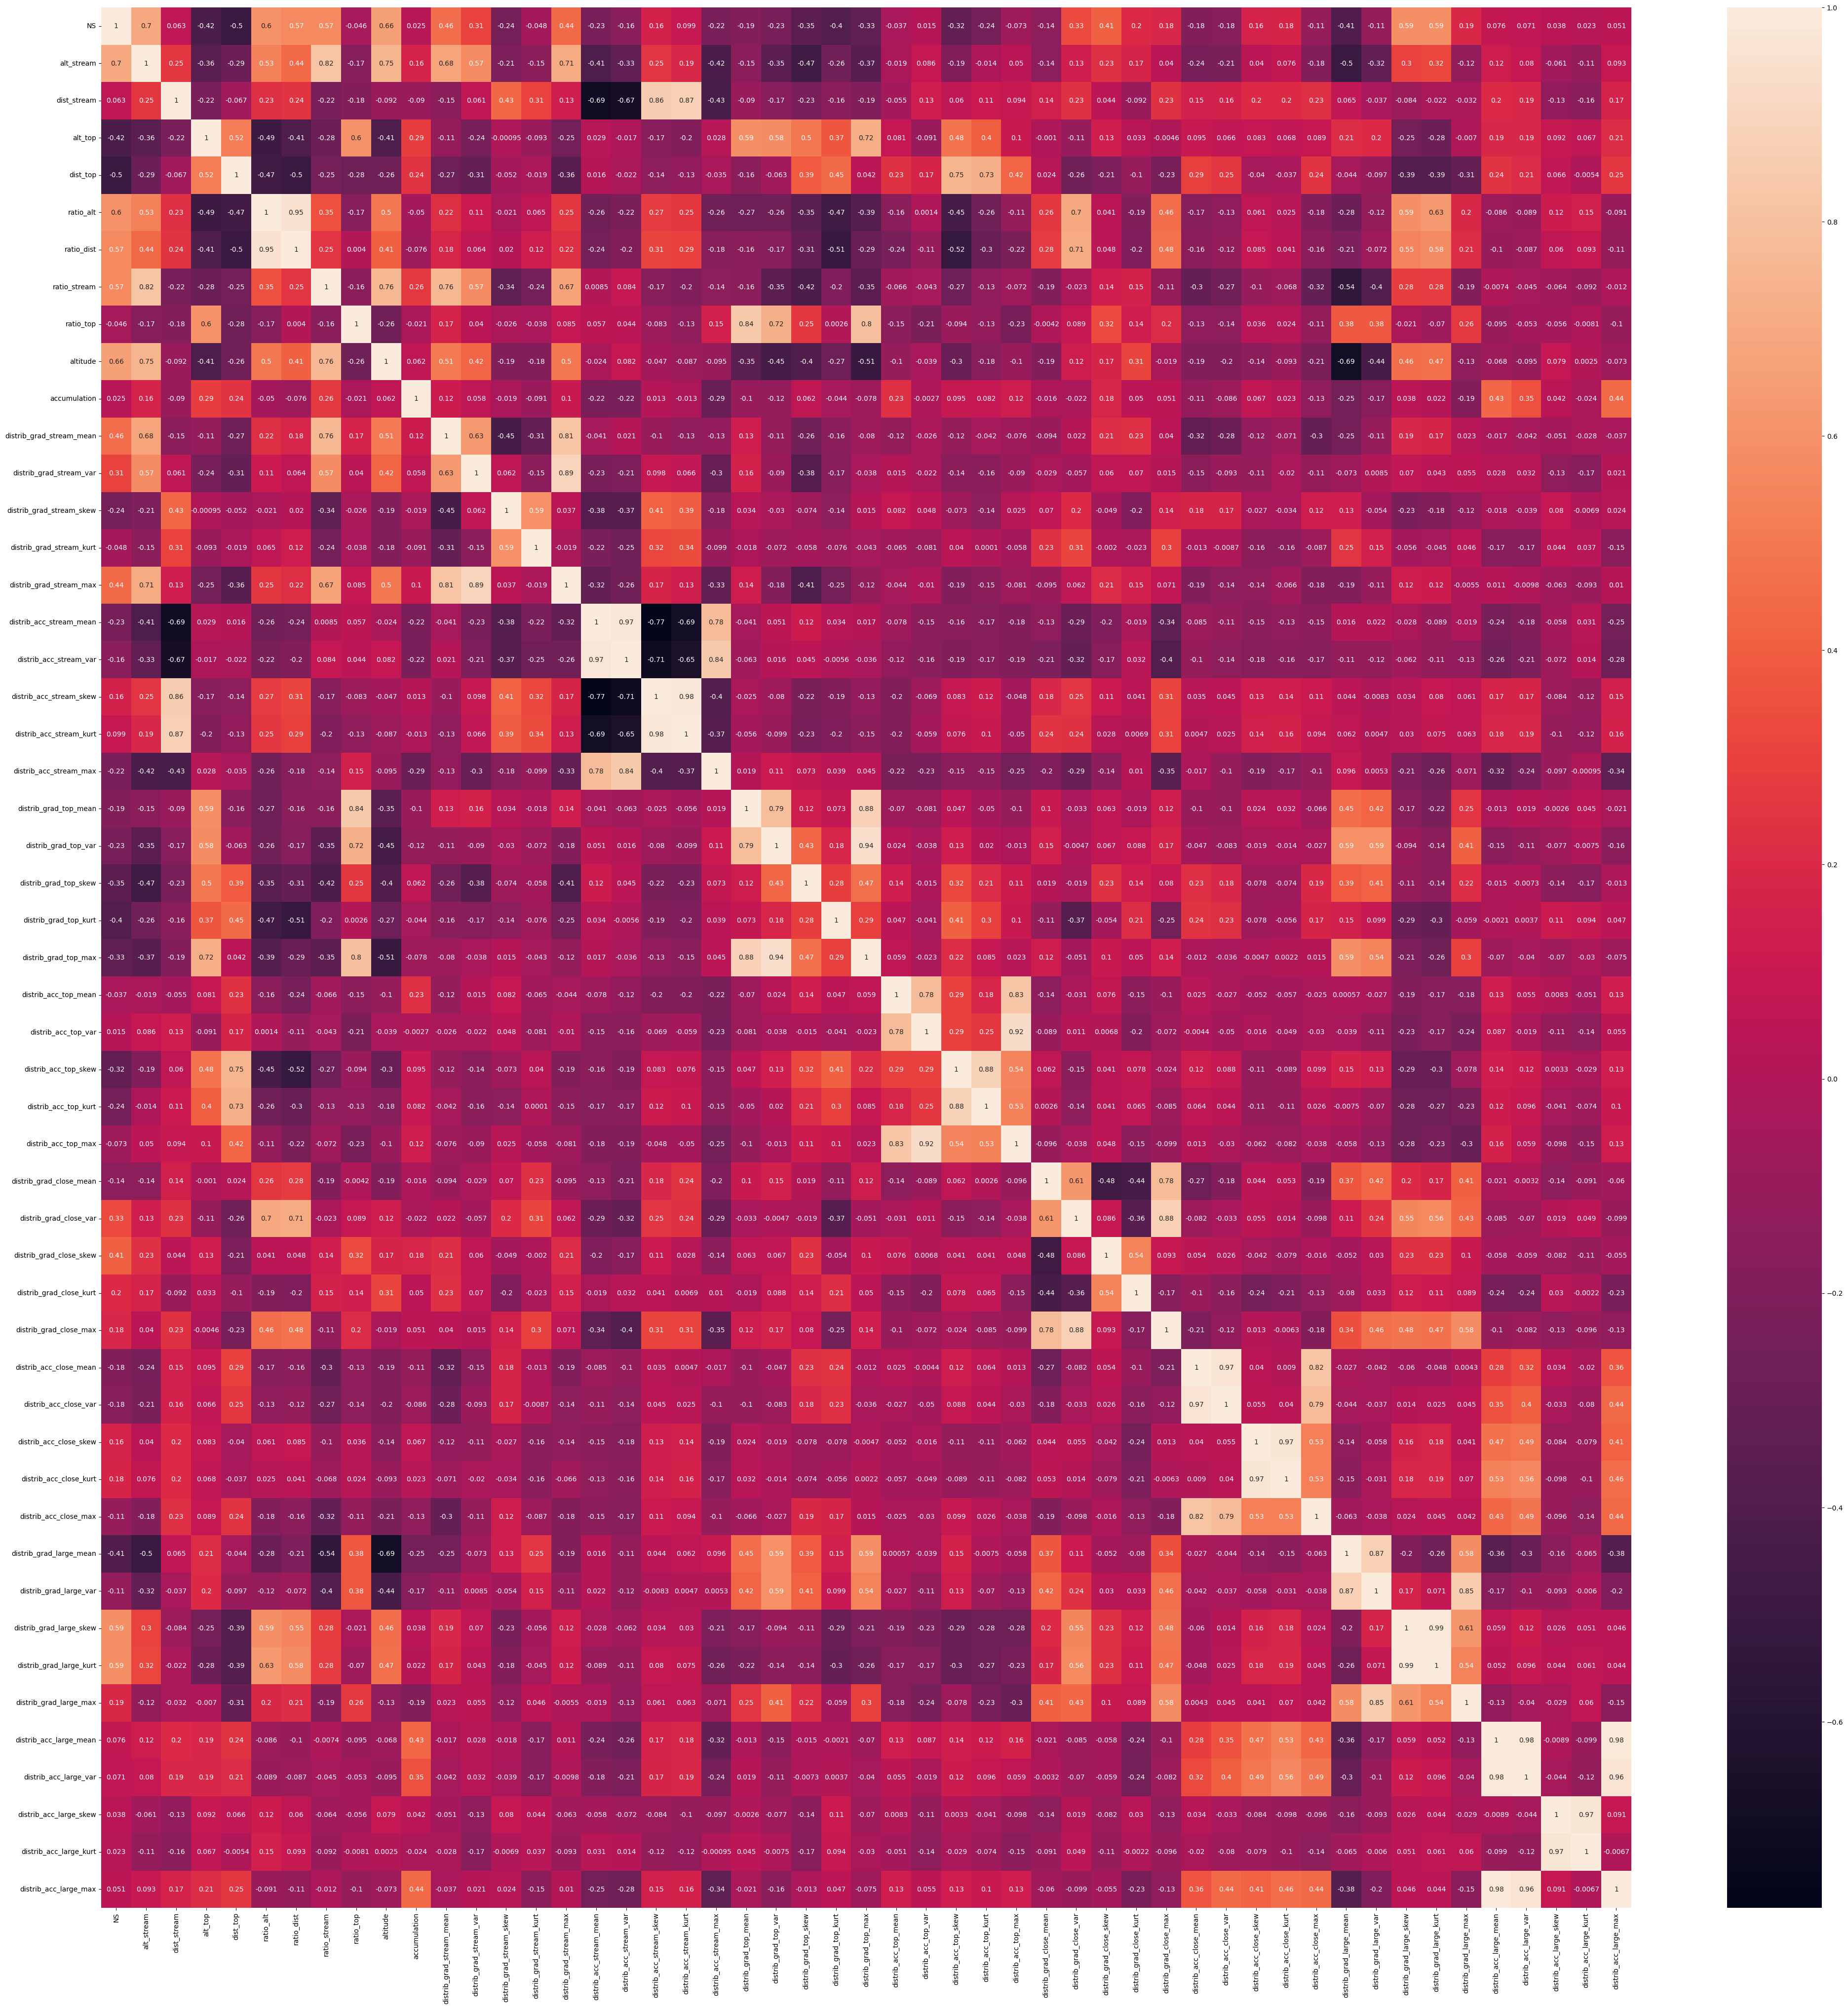

In [56]:
#On peut afficher les corrélations (inutile ici avec seulement 50 lignes pour l'exemple)

plt.figure(figsize=(50, 50))
sns.heatmap(dataset[dataset["top"]==dataset["top"]].dropna().drop(["CODE_OUVRA", "LON", "LAT", "DATE", "top", "stream"], axis=1).corr(), annot=True)

In [65]:
#Enfin, on peut entrainer notre modèle et voir ses performances (inutile ici avec seulement 50 lignes pour l'exemple)

X = dataset[dataset["top"]==dataset["top"]].dropna().drop(["CODE_OUVRA", "LON", "LAT", "DATE", "top", "stream", "NS"], axis=1).astype("float")
y = dataset.loc[X.index, "NS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100)

model.fit(X_train, y_train)

RandomForestRegressor()

RMSE (en %): 46.2 %
Corrélation entre les prédictions et les vraies valeurs: 15.2 %


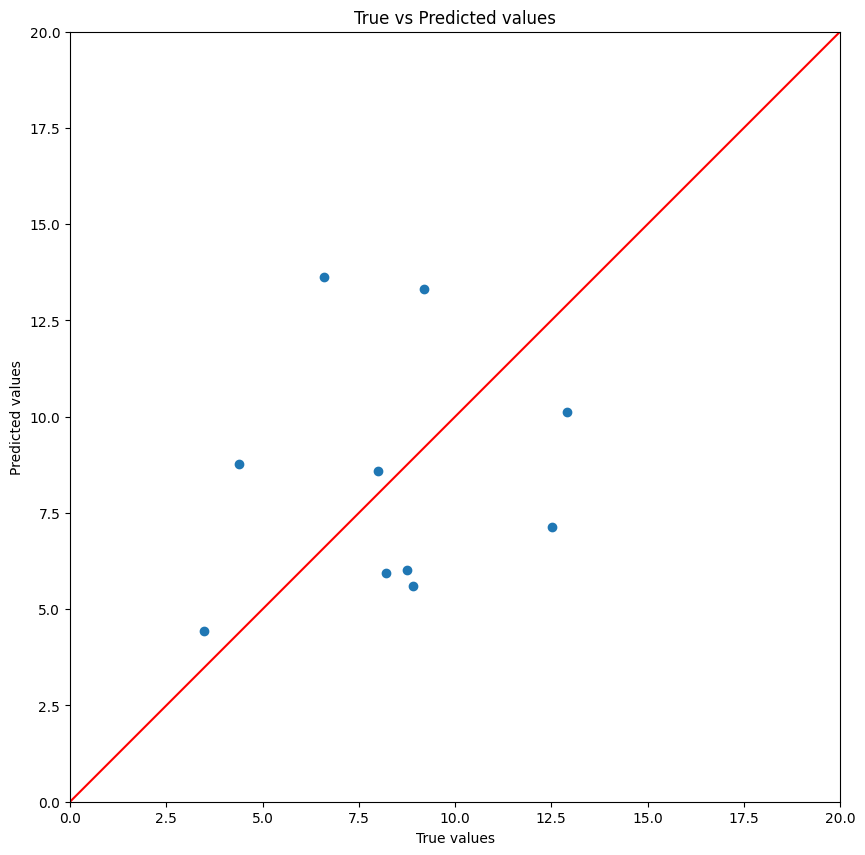

In [72]:
y_pred = model.predict(X_test)

print(f"RMSE (en %): {round(np.sqrt(np.mean((y_test - y_pred)**2))/np.mean(y_test) * 100, 3)} %")
print(f"Corrélation entre les prédictions et les vraies valeurs: {np.corrcoef(y_test, y_pred)[0, 1].round(3)*100} %")

max_limit = max(20, 20)

plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)

T = np.arange(0, max_limit + 1)
plt.plot(T, T, 'r')

plt.xlim(0, max_limit)
plt.ylim(0, max_limit)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('True vs Predicted values')

plt.show()